In [84]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import pygsheets
import pickle as pkl
import pandas as pd
import load_data
import seaborn as sns
sys.path.append('modeling')
from viz import viz, viz_interactive
from exponential_modeling import estimate_deaths
from fit_and_predict import fit_and_predict

outcomes = ['tot_cases', 'tot_deaths']
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
df_county = df_county.sort_values('tot_deaths', ascending=False)
NUM_DAYS_LIST = [1, 2, 3]
# df_county = exponential_modeling.estimate_deaths(df_county) # adds key 
for num_days_in_future in NUM_DAYS_LIST: # 1 is tomorrow
    '''
    df_county = fit_and_predict(df_county, method='ensemble', 
                                outcome='tot_deaths',
                                mode='predict_future',
                                target_day=[num_days_in_future])
    '''
    output_key = f'Predicted Deaths {num_days_in_future}-day'
    df_county = estimate_deaths(df_county, mode='predict_future',
                                method='exponential', target_day=[num_days_in_future],
                                output_key=output_key) # adds key 
    vals = df_county[output_key].values
    df_county[output_key] = [vals[i][0] for i in range(df_county.shape[0])]
df = df_hospital.merge(df_county, how='left', on='countyFIPS')
df[outcomes] = df[outcomes].fillna(0)
# note this many hospitals couldn't be matched to a county - we don't know how to include them!
print('# unmatched hospitals:', df['countyFIPS'].isna().sum())
print('# matched hospitals:', (~df['countyFIPS'].isna()).sum())
print('# academic matched hospitals:', (~df['countyFIPS'].isna() & df['IsAcademicHospital']).sum())
print('# academic matched hospitals w/ ICU beds:', (~df['countyFIPS'].isna() & 
                                                    df['IsAcademicHospital'] &
                                                    df['ICU Beds'] > 0).sum())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
# unmatched hospitals: 598
# matched hospitals: 6545
# academic matched hospitals: 1215
# academic matched hospitals w/ ICU beds: 1087


In [85]:
# aggregate employees by county
total_emp_county = df.groupby('countyFIPS').agg({'Hospital Employees': 'sum'})
total_emp_county = total_emp_county.rename(columns={'Hospital Employees': 'Hospital Employees in County'})
df_county = pd.merge(df_county, total_emp_county, how='left', on='countyFIPS')
df = pd.merge(df, total_emp_county, how='left', on='countyFIPS')

# filter hospitals
df = df[~df['countyFIPS'].isna() & df['IsAcademicHospital'] & df['Hospital Employees'] > 0]
df = df.sort_values(by=['tot_deaths', 'Hospital Employees'], ascending=False)


# fraction of employees out of all county hospitals
df['Frac Hospital Employees of County'] = df['Hospital Employees'] / df['Hospital Employees in County']

In [86]:
df['Predicted Deaths Hospital-level'] = df['Predicted Deaths 1-day'] * df['Frac Hospital Employees of County']

**look at most affected hospitals**

In [66]:
# d.groupby('countyFIPS').head(1).head(5) # look at top counties

In [67]:
# df.head(100)

In [ ]:
R, C  = 1, 2
nonzero = df['Predicted Deaths 1-day'] > 0
plt.figure(dpi=300)
plt.subplot(R, C, 1)
plt.hist(df['Predicted Deaths 1-day'][nonzero])
plt.xlabel('Predicted Number of Deaths')
plt.ylabel('Num Hospitals')

plt.subplot(R, C, 2)
plt.hist(df['Predicted Deaths Hospital-level'][nonzero])
plt.xlabel('Predicted Number of Deaths * Num Employees')
plt.ylabel('Num Hospitals')
plt.tight_layout()
plt.show()

In [87]:
df.keys()

Index(['Unnamed: 0', 'CMS Certification Number', 'Hospital Name',
       'Street Address_x', 'City_x', 'State_x', 'ZIP', 'System Affiliation',
       'Type of Facility', 'Hospital Employees',
       ...
       'deaths', 'cases', 'tot_deaths', 'tot_cases', 'Predicted Deaths 1-day',
       'Predicted Deaths 2-day', 'Predicted Deaths 3-day',
       'Hospital Employees in County', 'Frac Hospital Employees of County',
       'Predicted Deaths Hospital-level'],
      dtype='object', length=7518)

In [91]:
df.sort_values('Predicted Deaths Hospital-level', ascending=False)[['Predicted Deaths Hospital-level', 'Hospital Name', 'State_x', 'Hospital Employees', 'tot_deaths']].head(10)

,Predicted Deaths Hospital-level,Hospital Name,Hospital Name,State_x,State_x,Hospital Employees,tot_deaths
3736,139.626946,Montefiore Hospital- Moses Campus,Montefiore Medical Center,NY,NY,18142.0,188.0
3732,77.408405,NewYork-Presbyterian Queens Hospital,Newyork-Presbyterian/Queens,NY,NY,3795.0,253.0
3717,63.130175,Jamaica Hospital Medical Center,Jamaica Hospital Medical Center,NY,NY,3095.0,253.0
3773,61.212813,NYC Health + Hospitals Elmhurst,Elmhurst Hospital Center,NY,NY,3001.0,253.0
3788,48.703361,Staten Island University Hospital,Staten Island University Hospital,NY,NY,5817.0,46.0
3806,43.936836,Maimonides Medical Center,Maimonides Medical Center,NY,NY,5622.0,185.0
3830,39.611890,NYC Health + Hospitals Queens,Queens Hospital Center,NY,NY,1942.0,253.0
3757,38.870554,New York Presbyterian/Weill Cornell Medical Ce...,New York Presbyterian Hospital,NY,NY,26491.0,103.0
3805,34.410535,Flushing Hospital Medical Center,Flushing Hospital Medical Center,NY,NY,1687.0,253.0
3860,32.987795,NYU Langone Hospital - Brooklyn,Lutheran Medical Center,NY,NY,4221.0,185.0


# correlations

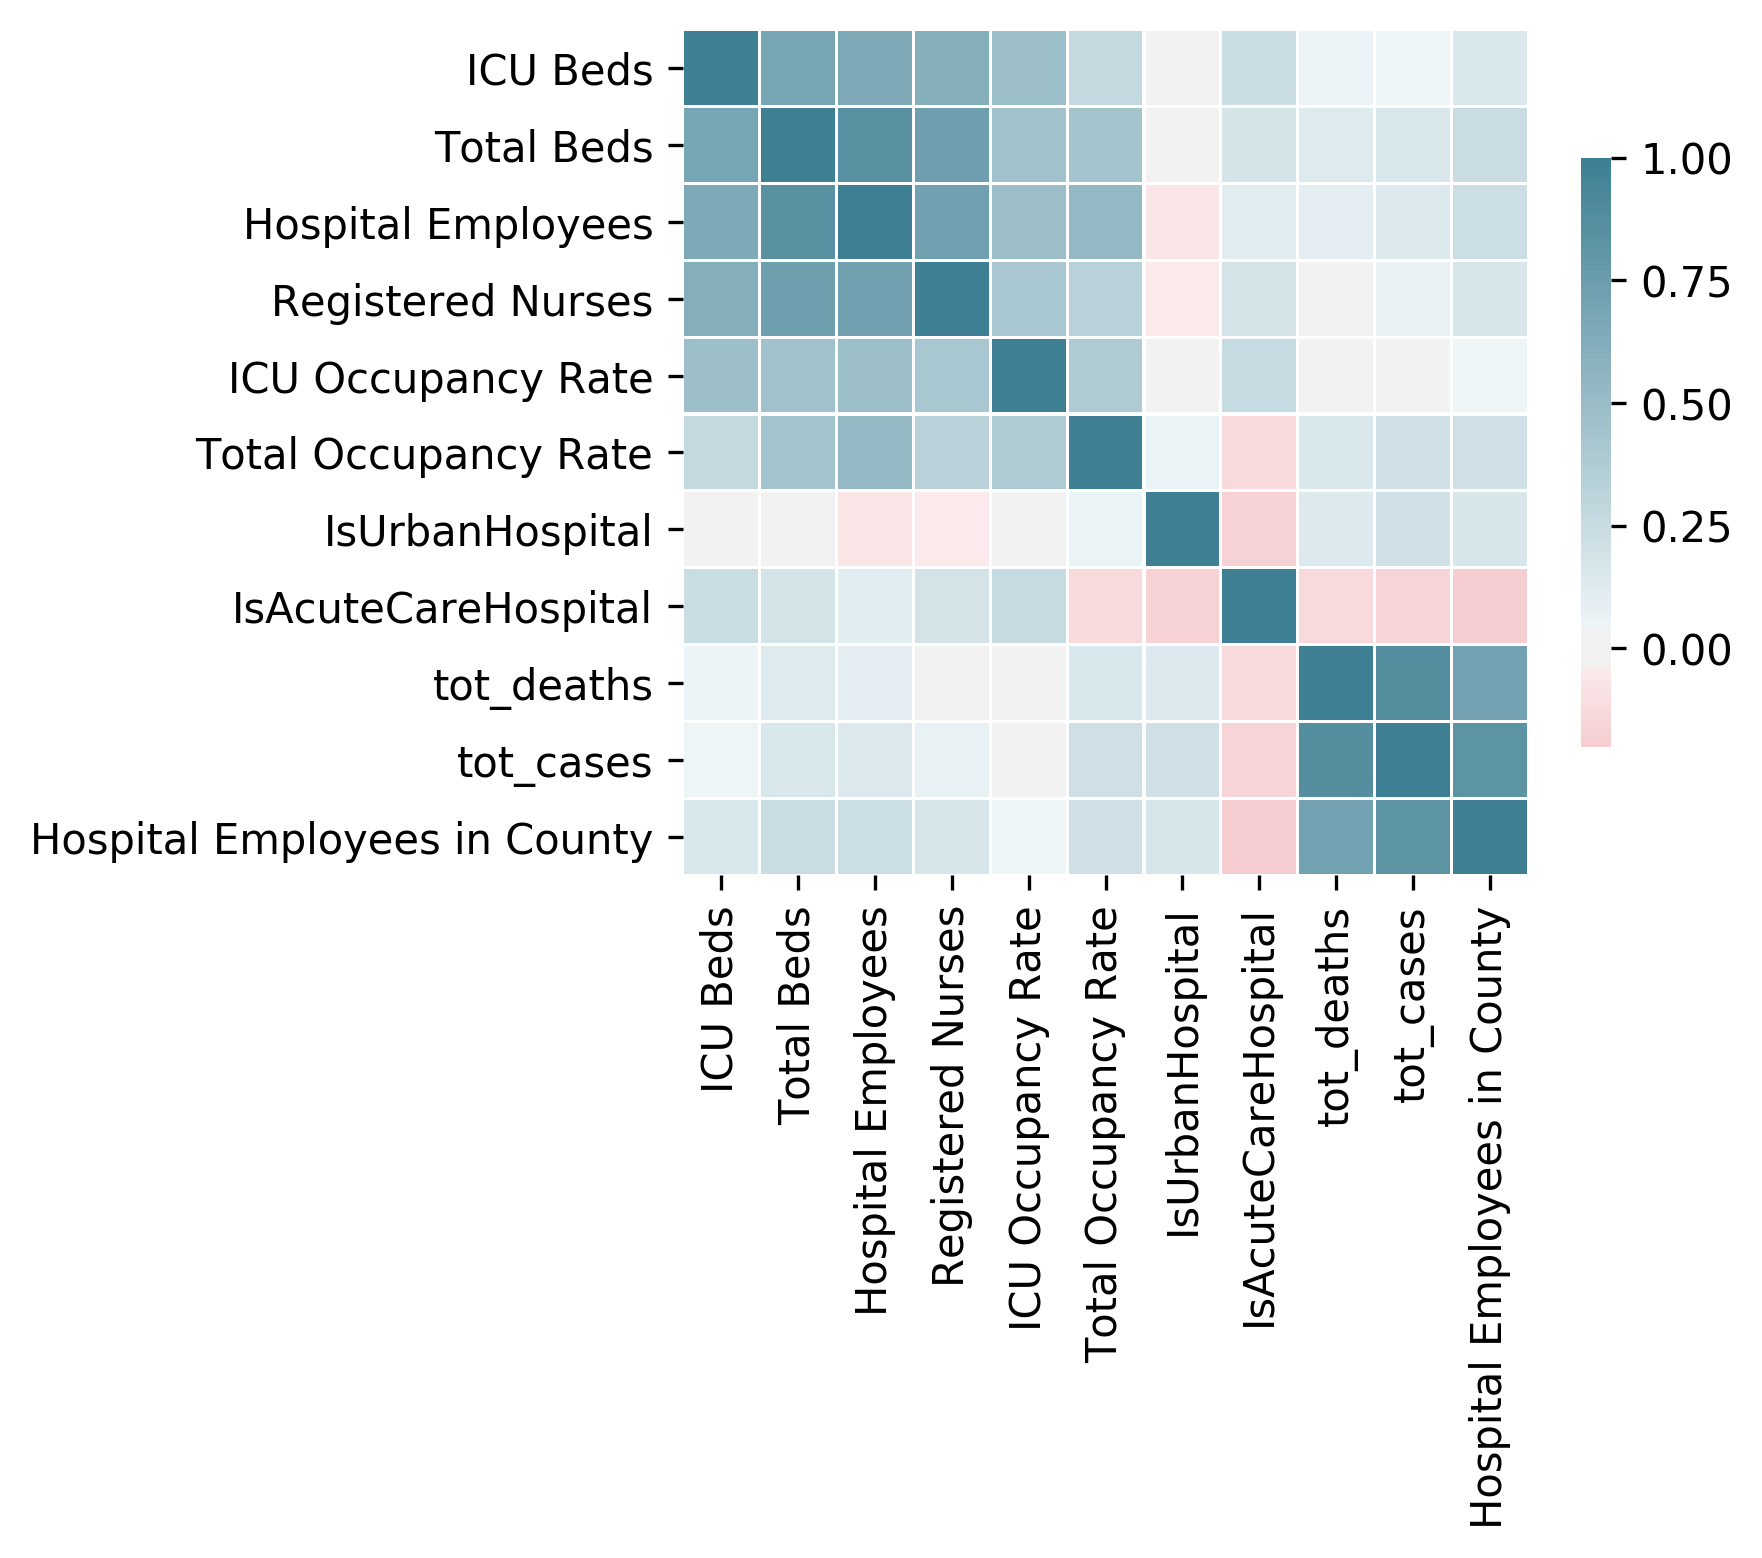

In [54]:
ks = ['ICU Beds', 'Total Beds', 
      'Hospital Employees', 'Registered Nurses',
      'ICU Occupancy Rate', 'Total Occupancy Rate',
      'Mortality national comparison',
      
#       'IsAcademicHospital', 
      'IsUrbanHospital',
      'IsAcuteCareHospital', 
      
      # preds
      'Predicted Deaths 1-day', 'Predicted Deaths 2-day',
      
      # county-level stuff
      'tot_deaths', 'tot_cases', 'Hospital Employees in County']



viz.corrplot(df[ks], SIZE=6)

In [49]:
df.keys()

Index(['Unnamed: 0', 'CMS Certification Number', 'Facility Name',
       'Street Address_x', 'City_x', 'State_x', 'ZIP', 'System Affiliation',
       'Type of Facility', 'Hospital Employees',
       ...
       '#Deaths_3/29/2020', 'deaths', 'cases', 'tot_deaths', 'tot_cases',
       'Predicted Deaths 1-day', 'Predicted Deaths 2-day',
       'Predicted Deaths 3-day', 'Hospital Employees in County',
       'Frac Hospital Employees of County'],
      dtype='object', length=7517)

**predicted num deaths**

# useful county-level plots

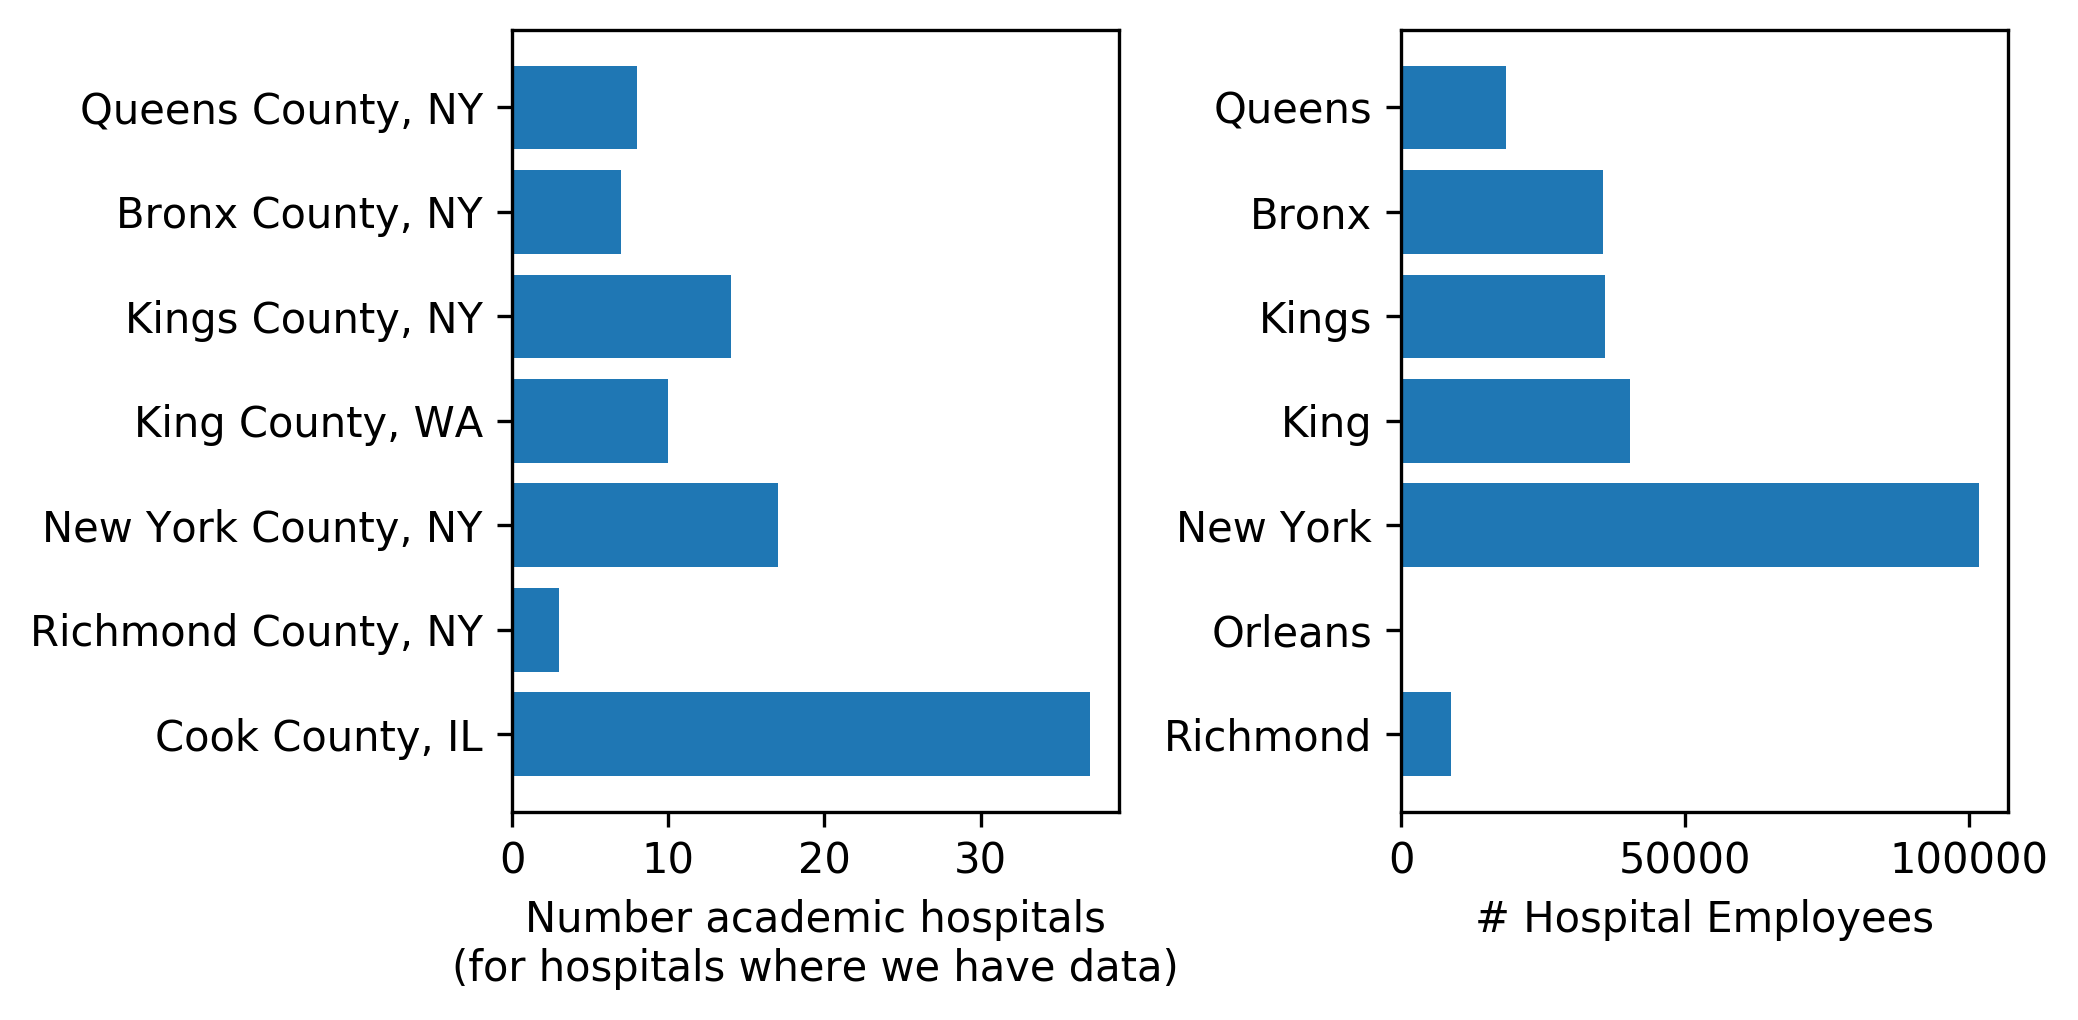

In [24]:
d = df

R, C = 1, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 3.5))


plt.subplot(R, C, 1)
c = 'County Name'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
# d = df[outcome_keys + hospital_keys]
# d = d.sort_values('New Deaths', ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals\n(for hospitals where we have data)')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['Hospital Employees in County'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('# Hospital Employees')

plt.tight_layout()
plt.show()

In [ ]:
d = df

R, C = 1, 2
NUM_COUNTIES = 7
plt.figure(dpi=500, figsize=(8, 4))


r = df_county
# cs = sns.diverging_palette(20, 220, n=NUM_COUNTIES)
cs = sns.color_palette("husl", 7)
for i in range(NUM_COUNTIES):
    row = df_county.iloc[i]
    deaths = np.array([x for x in row['deaths'] if x > 0])
    cases = np.array([x for x in row['cases'] if x > 0])
    
    CASES_ALIGNMENT = 100
    idx_align = np.where(cases > CASES_ALIGNMENT)[0][0]
    n = cases.size
    
    DEATHS_ALIGNMENT = 10
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size

    
    plt.subplot(R, C, 1)
    plt.plot(np.arange(n) - idx_align, cases, alpha=0.5, label=row['CountyName'] + ' County', color=cs[i])
#     plt.yscale('log')
    plt.ylabel('Cumulative confirmed cases')
    plt.xlabel(f'Days since {CASES_ALIGNMENT} cases')
    plt.legend()
    
    plt.subplot(R, C, 2)
    plt.plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5, color=cs[i])
#     plt.yscale('log')
    plt.ylabel('Cumulative deaths')
    plt.xlabel(f'Days since {DEATHS_ALIGNMENT} deaths')
plt.tight_layout()
plt.show()

# intra-county plots

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



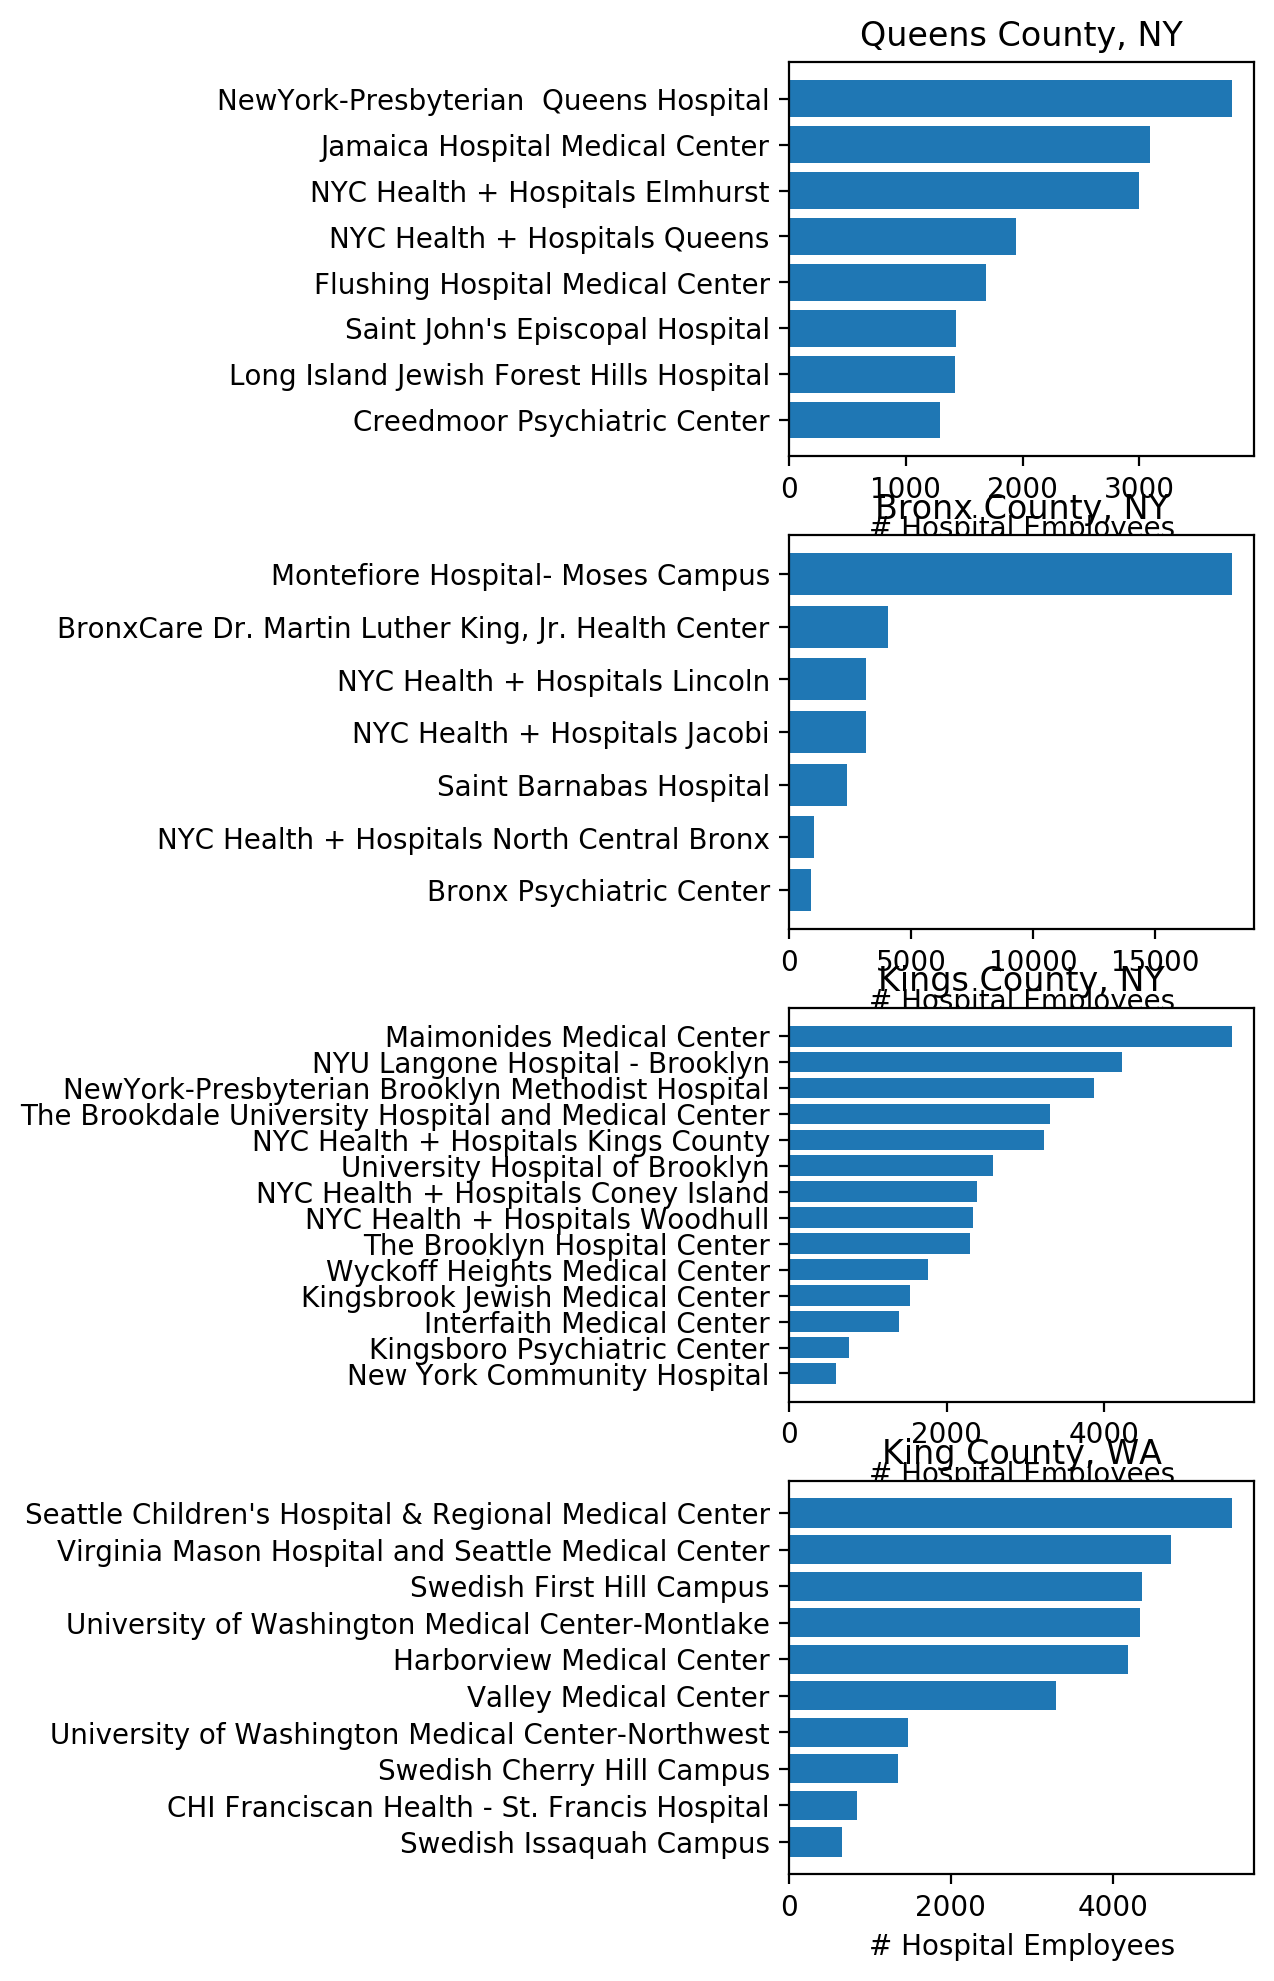

In [41]:
county_names = d[c].unique()[:NUM_COUNTIES]
R, C = 4, 1
plt.figure(figsize=(C * 3, R * 3), dpi=200)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    cn = county_names[i]
    dc = d[d[c] == cn]
    plt.barh(dc['Facility Name'][::-1], dc['Hospital Employees'][::-1])
    plt.title(cn)
    plt.xlabel('# Hospital Employees')
plt.tight_layout()
# plt.subplots_adjust(bottom=1)
plt.show()